In [1]:
from influxdb_client import InfluxDBClient
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.varmax import VARMAX
from random import random

In [9]:
df = pd.read_csv("dataframe_11g_5m.csv")
n_days = 11
df.time = pd.to_datetime(df.time, dayfirst = True)
df.set_index('time',inplace=True)
points_per_day = 288 
df.tail()

,temperature,humidity,pressure,people
time,,,,
2020-07-18 13:05:00+00:00,29.25,47.35,1018.4,1.0
2020-07-18 13:10:00+00:00,29.25,47.35,1018.4,1.0
2020-07-18 13:15:00+00:00,29.25,47.35,1018.4,1.0
2020-07-18 13:20:00+00:00,29.25,47.35,1018.4,1.0
2020-07-18 13:25:00+00:00,29.25,47.35,1018.4,1.0


In [10]:
print(df['temperature'].isnull().sum())
print(df['humidity'].isnull().sum())
print(df['pressure'].isnull().sum())
print(df['people'].isnull().sum())

0
0
0
0


In [11]:
df['temperature'] = df['temperature'].fillna(method='backfill').fillna(method='ffill')
df['humidity'] = df['humidity'].fillna(method='backfill').fillna(method='ffill')
df['pressure'] = df['pressure'].fillna(method='backfill').fillna(method='ffill')
df['people'] = df['people'].fillna(method='backfill').fillna(method='ffill')

In [12]:
points_per_day = int(len(df)/n_days) 
points_per_day

288

In [15]:
# divide in train e test
size = len(df)- (points_per_day*1)
# size = int(len(df)*0.9)
df_train, df_test = df.iloc[:size], df.iloc[size:]

In [20]:
start_date = df_test.index[0]
end_date = df_test.index[points_per_day-1]

# Temperature

In [46]:
# fit model
#model = ExponentialSmoothing(df_train.temperature, seasonal="add",seasonal_periods = 288)#trend = "add")#, seasonal = "mul", seasonal_periods=500)
#model_fit = model.fit()#optimized=True)#, use_boxcox=True, remove_bias=True)

model = VARMAX(df_train[['temperature', 'humidity', 'people','pressure']], order=(1, 0))
model_fit = model.fit(disp=False)

print(model_fit.summary())

/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  warnings.warn('No frequency information was'


                                           Statespace Model Results                                          
Dep. Variable:     ['temperature', 'humidity', 'people', 'pressure']   No. Observations:                 2880
Model:                                                    VARMA(1,1)   Log Likelihood                3989.060
                                                         + intercept   AIC                          -7886.121
Date:                                               Mon, 20 Jul 2020   BIC                          -7611.706
Time:                                                       00:31:01   HQIC                         -7787.209
Sample:                                                   07-07-2020                                         
                                                        - 07-17-2020                                         
Covariance Type:                                                 opg                                         
Ljung-Box 

In [47]:
end_pred = points_per_day-1
df_forecast = model_fit.forecast(end_pred)

/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


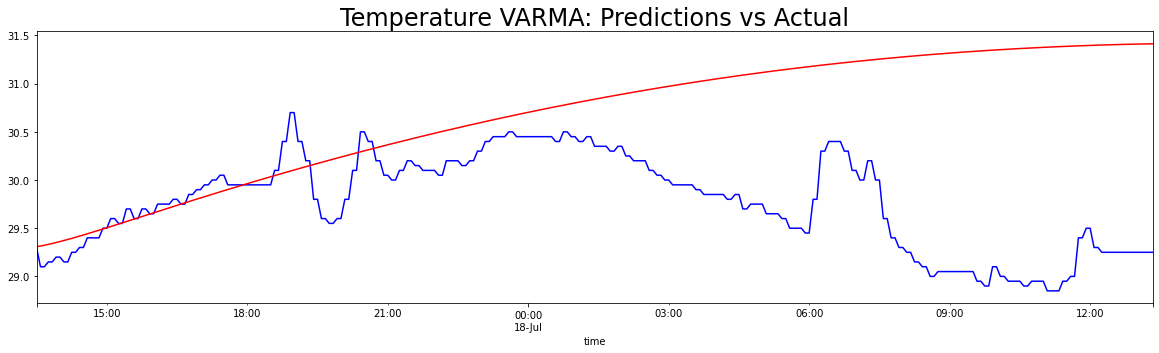

ABSOLUTE ERROR 0.9331006817799742
MSE 1.5959863832604317


In [48]:
#df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.temperature[:end_pred].plot(figsize = (20,5),color = "blue")
df_forecast.temperature.plot(color = "red")
plt.title("Temperature VARMA: Predictions vs Actual", size = 24)
plt.show()                          

print("ABSOLUTE ERROR "+str(mean_absolute_error(df_test.temperature[:end_pred], df_forecast.temperature)))
print("MSE "+str(mean_squared_error(df_test.temperature[:end_pred], df_forecast.temperature)))

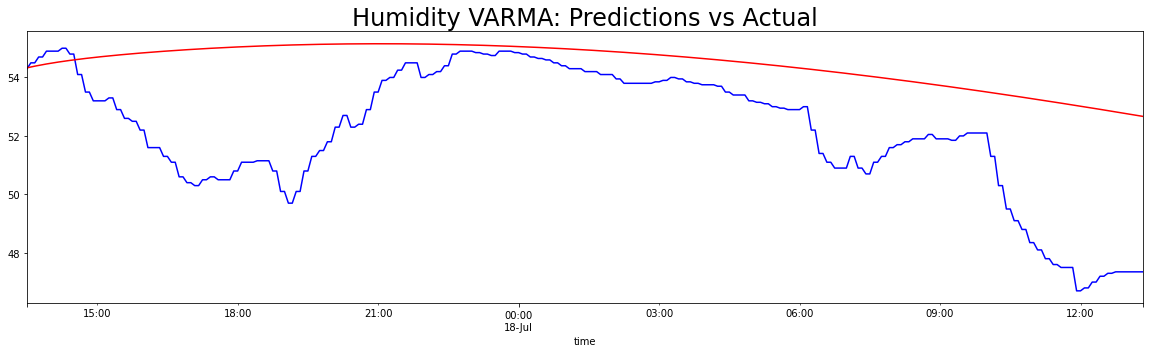

ABSOLUTE ERROR 2.308347356591222
MSE 8.391401438966751


In [49]:
#df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.humidity[:end_pred].plot(figsize = (20,5),color = "blue")
df_forecast.humidity.plot(color = "red")
plt.title("Humidity VARMA: Predictions vs Actual", size = 24)
plt.show()                          

print("ABSOLUTE ERROR "+str(mean_absolute_error(df_test.humidity[:end_pred], df_forecast.humidity)))
print("MSE "+str(mean_squared_error(df_test.humidity[:end_pred], df_forecast.humidity)))

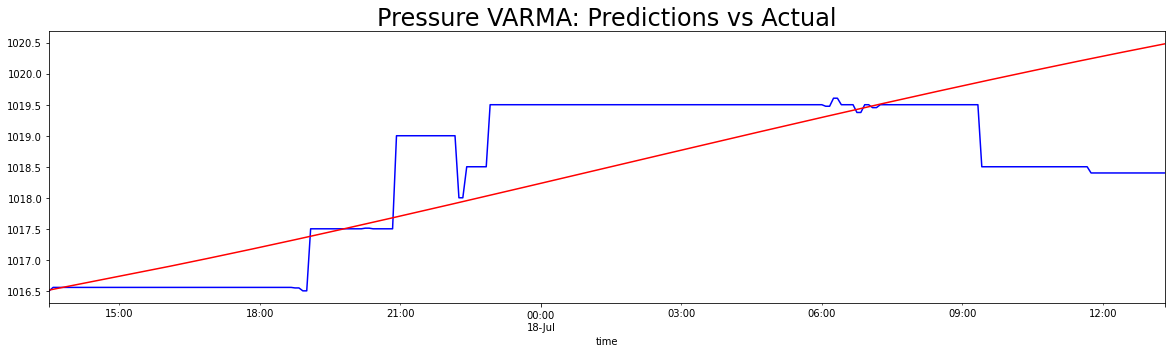

ABSOLUTE ERROR 0.7315180868427466
MSE 0.8917326824745633


In [50]:
#df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.pressure[:end_pred].plot(figsize = (20,5),color = "blue")
df_forecast.pressure.plot(color = "red")
plt.title("Pressure VARMA: Predictions vs Actual", size = 24)
plt.show()                          

print("ABSOLUTE ERROR "+str(mean_absolute_error(df_test.pressure[:end_pred], df_forecast.pressure)))
print("MSE "+str(mean_squared_error(df_test.pressure[:end_pred], df_forecast.pressure)))

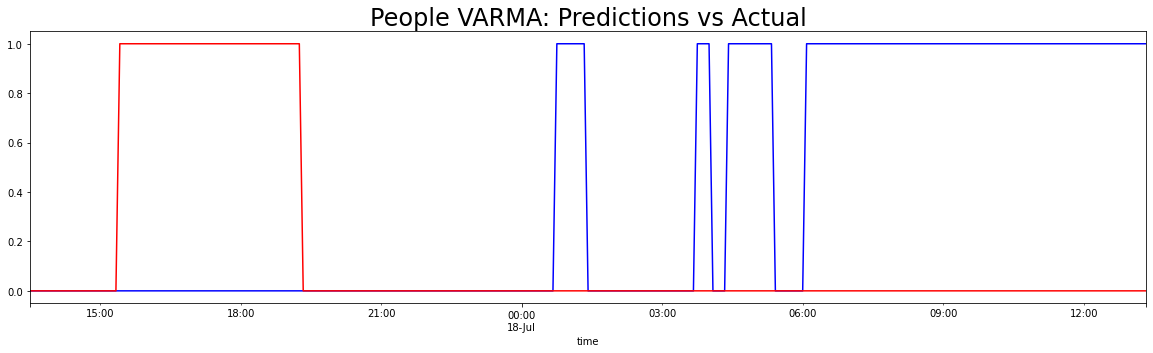

ABSOLUTE ERROR 0.554006968641115
MSE 0.554006968641115


In [51]:
#df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.people[:end_pred].plot(figsize = (20,5),color = "blue")

rounded = df_forecast.people.round()

rounded.plot(color = "red")
plt.title("People VARMA: Predictions vs Actual", size = 24)
plt.show()                          

print("ABSOLUTE ERROR "+str(mean_absolute_error(df_test.people[:end_pred], rounded)))
print("MSE "+str(mean_squared_error(df_test.people[:end_pred],rounded)))